In [2]:
import sys

import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

# Plotting
%matplotlib inline
plt.rcParams['font.size'] = 18.0
plt.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# For MB Pro retina display
%config InlineBackend.figure_format = 'retina'

# For auto-reloading external modules
%load_ext autoreload
%autoreload 2

sys.path.append('../')
import profiler
import utils
from models import biggan

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def run_G(resolution=128, batch_size=32, n_classes=1000, num_itr=500, outfile=None):
    G = biggan.Generator(resolution=128).to(device)
    z_, y_ = utils.prepare_z_y(batch_size, G.dim_z, n_classes, device=device)
    with torch.no_grad():
        for _ in range(num_itr):
            out = G(z_, y_, embed=True)
    del G, z_, y_
    return prof


def plot_usage(pr, gpu_index=0, smooth_amount=0.00):
    fig, axs = plt.subplots(5, sharex=True)
    
    time = pr.time_profile()
    power = pr.power_profile()
    gpu_power = pr.gpu_power_profile(gpu_index=gpu_index)
    util = pr.gpu_util_profile(gpu_index=gpu_index)
    mem = pr.gpu_mem_profile(gpu_index=gpu_index)
    temp = pr.gpu_temp_profile(gpu_index=gpu_index)
    
    for label, data, ax in zip(['Power', 'GPU Power', 'Util', 'Memory', 'Temperature'],
                               [power, gpu_power, util, mem, temp], axs.flat):
        ax.plot(time, data)
        ax.set(ylabel=label)

    plt.xlabel('Time (sec)', fontsize='x-large')
    axs[0].set_title('Profiling Summary', fontsize='xx-large')
    fig.tight_layout()
    plt.show()

In [4]:
with profiler.Profile(outfile=None) as prof:
    run_G(batch_size=8)
    run_G(batch_size=16)
    run_G(batch_size=32)
    run_G(batch_size=64)
    run_G(batch_size=128)
    run_G(batch_size=256)

In [6]:
profile_run = profiler.ProfileRun(prof.data)

Total time:      339.293501
Total Power:     0.5666046570629061 Wh
Total GPU Power: 0.19914092672886835 Wh


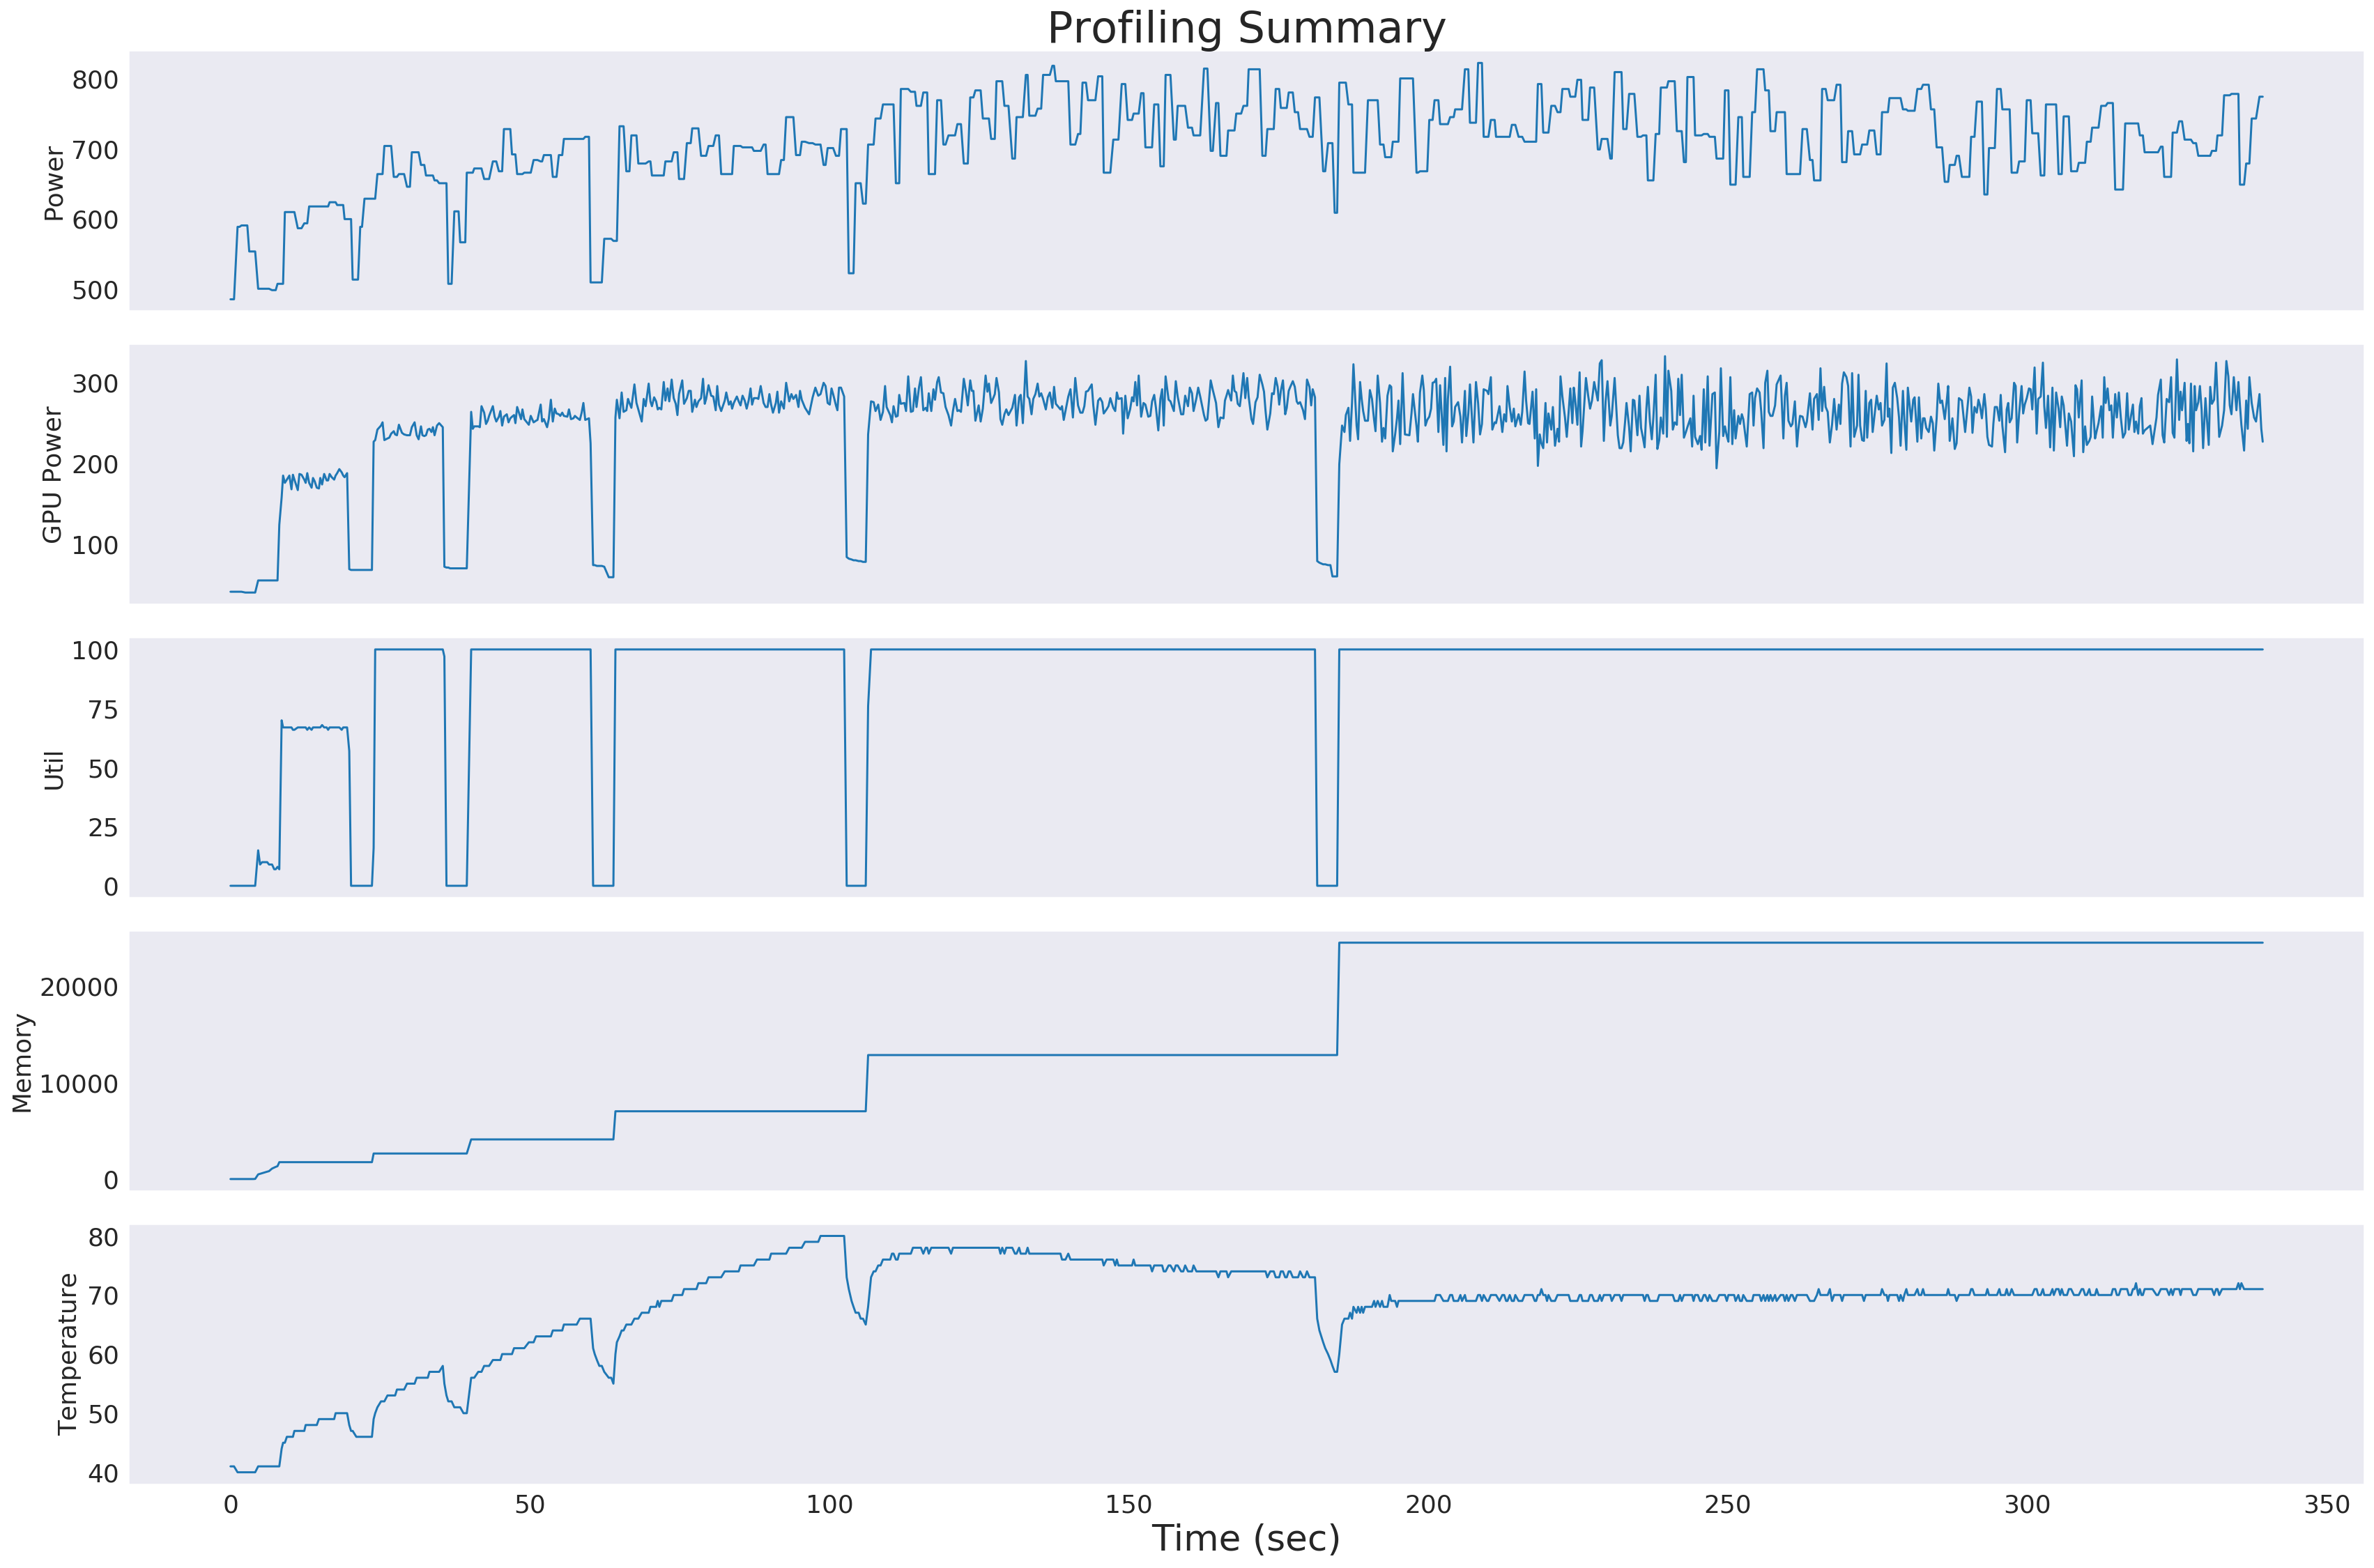

In [7]:
gpu_index = 0
profile_run.print_stats(gpu_index=gpu_index)
plot_usage(profile_run, gpu_index=gpu_index)